In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
#import json
import datetime
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt

#from haversine import haversine
#from datetime import datetime

# 1.1 Taxi data

In [2]:
# import datasets: every month individually

df_jan = pd.read_csv("data/taxi/Taxi_Trips-1.csv")
df_feb = pd.read_csv("data/taxi/Taxi_Trips-2.csv")
df_mar = pd.read_csv("data/taxi/Taxi_Trips-3.csv")
df_apr = pd.read_csv("data/taxi/Taxi_Trips-4.csv")
df_may = pd.read_csv("data/taxi/Taxi_Trips-5.csv")
df_jun = pd.read_csv("data/taxi/Taxi_Trips-6.csv")
df_jul = pd.read_csv("data/taxi/Taxi_Trips-7.csv")
df_aug = pd.read_csv("data/taxi/Taxi_Trips-8.csv")
df_sept = pd.read_csv("data/taxi/Taxi_Trips-9.csv")
df_oct = pd.read_csv("data/taxi/Taxi_Trips-10.csv")
df_nov = pd.read_csv("data/taxi/Taxi_Trips-11.csv")
df_dec = pd.read_csv("data/taxi/Taxi_Trips-12.csv")

In [3]:
# combining the dataframes to one (for the whole year)

df_chicago = pd.concat([df_jan,df_feb,df_mar,df_apr,df_may,df_jun,df_jul,df_aug,df_sept,
           df_oct,df_nov,df_dec], axis=0)

In [4]:
df_chicago = df_chicago.reset_index(drop = True)

In [5]:
df_chicago.columns = df_chicago.columns.str.strip().str.replace(' ','_')

In [6]:
# change type of Trip_Start_Timestamp and Trip_End_Timestamp to datetime object

df_chicago['Trip_Start_Timestamp'] = pd.to_datetime(df_chicago['Trip_Start_Timestamp'])
df_chicago['Trip_End_Timestamp'] = pd.to_datetime(df_chicago['Trip_End_Timestamp'])

In [7]:
df_chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27217716 entries, 0 to 27217715
Data columns (total 24 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip_ID                     object        
 1   Taxi_ID                     object        
 2   Trip_Start_Timestamp        datetime64[ns]
 3   Trip_End_Timestamp          datetime64[ns]
 4   Trip_Seconds                float64       
 5   Trip_Miles                  float64       
 6   Pickup_Census_Tract         float64       
 7   Dropoff_Census_Tract        float64       
 8   Pickup_Community_Area       float64       
 9   Dropoff_Community_Area      float64       
 10  Fare                        float64       
 11  Tips                        float64       
 12  Tolls                       float64       
 13  Extras                      float64       
 14  Trip_Total                  float64       
 15  Payment_Type                object        
 16  Company         

In [8]:
df_chicago.head()

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,eda829a425ca1da13e1130c700c876881e26ff9a,b47c583b142d75b42882975eaab19c6cb98d8268601657...,2013-01-01,2013-01-01 00:15:00,600.0,3.0,NaN,NaN,NaN,NaN,...,9.65,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0c2b3705c9748a5949bf5b7d727b2d1f2e18805f,c2280976049b22e58ce53a17263114616be76981b9ac56...,2013-01-01,2013-01-01 00:30:00,1320.0,12.3,NaN,NaN,NaN,NaN,...,26.25,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c15dc571c96c36e44bc4ed50f40330e9f0a21650,294ae9e2f433bb460731f9199b1837de3cf88ad987a42b...,2013-01-01,2013-01-01 00:30:00,1320.0,6.3,NaN,NaN,NaN,NaN,...,19.45,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3c979de8d901f317228a40673c3923d72104b92c,2db2ec3555e44930a5d41596cb7935af41c30c30381672...,2013-01-01,2013-01-01 01:30:00,5520.0,88.8,1.703106e+10,NaN,6.0,NaN,...,317.81,Credit Card,NaN,41.942585,-87.656644,POINT (-87.6566440918 41.9425851797),NaN,NaN,NaN,57.0
4,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,11.45,Cash,NaN,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0


## Cleaning the dataframe: `df_chicago`

### General:

In [9]:
print(f"Number of duplicated rows: {len(df_chicago)-len(df_chicago.drop_duplicates(keep=False))}")

Number of duplicated rows: 0


In [10]:
# check if there are duplicated Trip_ID's

print(f"Number of duplicated Trips ID's: {df_chicago.duplicated(subset=['Trip_ID']).sum()}")

Number of duplicated Trips ID's: 0


In [11]:
df_chicago.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27217716 entries, 0 to 27217715
Data columns (total 24 columns):
 #   Column                      Non-Null Count     Dtype         
---  ------                      --------------     -----         
 0   Trip_ID                     27217716 non-null  object        
 1   Taxi_ID                     27217300 non-null  object        
 2   Trip_Start_Timestamp        27217716 non-null  datetime64[ns]
 3   Trip_End_Timestamp          27214283 non-null  datetime64[ns]
 4   Trip_Seconds                26089923 non-null  float64       
 5   Trip_Miles                  27217508 non-null  float64       
 6   Pickup_Census_Tract         16420305 non-null  float64       
 7   Dropoff_Census_Tract        15995630 non-null  float64       
 8   Pickup_Community_Area       22565506 non-null  float64       
 9   Dropoff_Community_Area      21804491 non-null  float64       
 10  Fare                        27217445 non-null  float64       
 11  Tips     

Since we don't need the column `Company`for any of our tasks and there are a lot of null values in it, we drop this column:

In [12]:
df_chicago.drop(columns=['Company'],inplace=True)

### Location based:

We drop the rows where either the `Pickup_Community_Area` or the `Dropoff_Community_Area` is null. These NaN values indicate a location outside of chicago. We don't need to do that with the `Pickup_Census_Trac` and `Dropoff_Census_Trac`, since if these columns are null, we have the community area (https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew (see at: "Columns in these Dataset")).

In [13]:
df_chicago.dropna(subset=['Pickup_Community_Area', 'Dropoff_Community_Area'], inplace = True)

In [14]:
df_chicago = df_chicago.reset_index(drop = True)
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Trip_Total,Payment_Type,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,1.0,11.45,Cash,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,0.0,3.85,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,0.0,4.84,Cash,41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0
3,9b4be9a70a4d74427e00adac7d90f469e36bddc7,a1b8eb24fa71867de525452474490e1c822269411962fe...,2013-01-01 00:00:00,2013-01-01 00:15:00,600.0,0.0,1.703107e+10,1.703106e+10,7.0,6.0,...,0.0,7.25,Cash,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),41.942577,-87.647079,POINT (-87.6470785093 41.942577185),68.0
4,091eda4ec41520d6ba96003f05eb10744f73aa82,e6f3cad6dc920f7782dccd76a1e0f147fc8361af905b4b...,2013-01-01 00:00:00,2013-01-01 00:15:00,720.0,0.0,1.703108e+10,1.703103e+10,8.0,3.0,...,0.0,15.25,Cash,41.895033,-87.619711,POINT (-87.6197106717 41.8950334495),41.972929,-87.650290,POINT (-87.6502900743 41.9729293173),37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21638627,a155865e7578ddd52ed77443c6fed7f981c694b1,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2013-12-31 23:45:00,2013-12-31 23:45:00,536.0,1.6,1.703106e+10,1.703103e+10,6.0,3.0,...,0.0,9.85,Credit Card,41.941556,-87.666289,POINT (-87.6662888874 41.941555829),41.965446,-87.663196,POINT (-87.6631958495 41.9654457842),57.0
21638628,35a5fe3a96ad453a9276112136c934a87379e8a5,341cead8979074196f3231099ef811c4e905d7031dd6d7...,2013-12-31 23:45:00,2014-01-01 00:15:00,1952.0,8.5,NaN,NaN,28.0,6.0,...,2.0,23.45,Cash,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),29.0
21638629,f6fa0574a62cab2fec2c9ea2cc075f8ff6ee19e5,c01573d08b208b89c0fdf054d7bc2820fe2abb9d326a80...,2013-12-31 23:45:00,2013-12-31 23:45:00,262.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,2.0,7.25,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),38.0
21638630,de95a68aae83de22d19a7999111f249e90eae812,5866e731fed5c82556c87a73b3ec2e19dd13d4cdc46a34...,2013-12-31 23:45:00,2013-12-31 23:45:00,352.0,0.7,1.703106e+10,1.703106e+10,6.0,6.0,...,0.0,7.05,Credit Card,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.934540,-87.643023,POINT (-87.6430228044 41.93453971580001),57.0


In [15]:
#len(df_chicago['Pickup_Centroid_Location'])-len(df_chicago['Pickup_Centroid_Location'].dropna())

In [16]:
df_chicago.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21638632 entries, 0 to 21638631
Data columns (total 23 columns):
 #   Column                      Non-Null Count     Dtype         
---  ------                      --------------     -----         
 0   Trip_ID                     21638632 non-null  object        
 1   Taxi_ID                     21638259 non-null  object        
 2   Trip_Start_Timestamp        21638632 non-null  datetime64[ns]
 3   Trip_End_Timestamp          21638632 non-null  datetime64[ns]
 4   Trip_Seconds                21636858 non-null  float64       
 5   Trip_Miles                  21638437 non-null  float64       
 6   Pickup_Census_Tract         15863491 non-null  float64       
 7   Dropoff_Census_Tract        15863491 non-null  float64       
 8   Pickup_Community_Area       21638632 non-null  float64       
 9   Dropoff_Community_Area      21638632 non-null  float64       
 10  Fare                        21638396 non-null  float64       
 11  Tips     

### `Trip_Miles` and `Trip_Seconds`:

In [17]:
print(f"Number of null values (NaN) in column 'Trip_Miles': {len(df_chicago['Trip_Miles'])-len(df_chicago['Trip_Miles'].dropna())}")
print(f"Number of null values (NaN) in column 'Trip_Seconds': {len(df_chicago['Trip_Seconds'])-len(df_chicago['Trip_Seconds'].dropna())}")

Number of null values (NaN) in column 'Trip_Miles': 195
Number of null values (NaN) in column 'Trip_Seconds': 1774


In [18]:
df_chicago.dropna(subset=['Trip_Miles','Trip_Seconds'], inplace = True)

Below we check for trips which have negative or zero miles and trips which have a duration of less than a minute:

In [19]:
miles_ = (df_chicago['Trip_Miles'] <= 0).sum()
seconds_ = (df_chicago['Trip_Seconds'] < 60).sum()
print(miles_)
print(seconds_)

9211247
689760


In [20]:
df_chicago = df_chicago[df_chicago['Trip_Miles'] > 0]
df_chicago = df_chicago[df_chicago['Trip_Seconds'] >= 60]

In [21]:
df_chicago.reset_index(drop = True)

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Trip_Total,Payment_Type,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,1.0,11.45,Cash,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,0.0,3.85,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,0.0,4.84,Cash,41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01 00:30:00,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,3.0,42.05,Cash,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),75.0
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:30:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,1.0,25.05,Cash,41.921126,-87.699754,POINT (-87.6997544065 41.9211259143),41.966834,-87.684018,POINT (-87.6840183712 41.9668340674),23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359780,a155865e7578ddd52ed77443c6fed7f981c694b1,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2013-12-31 23:45:00,2013-12-31 23:45:00,536.0,1.6,1.703106e+10,1.703103e+10,6.0,3.0,...,0.0,9.85,Credit Card,41.941556,-87.666289,POINT (-87.6662888874 41.941555829),41.965446,-87.663196,POINT (-87.6631958495 41.9654457842),57.0
12359781,35a5fe3a96ad453a9276112136c934a87379e8a5,341cead8979074196f3231099ef811c4e905d7031dd6d7...,2013-12-31 23:45:00,2014-01-01 00:15:00,1952.0,8.5,NaN,NaN,28.0,6.0,...,2.0,23.45,Cash,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),29.0
12359782,f6fa0574a62cab2fec2c9ea2cc075f8ff6ee19e5,c01573d08b208b89c0fdf054d7bc2820fe2abb9d326a80...,2013-12-31 23:45:00,2013-12-31 23:45:00,262.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,2.0,7.25,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),38.0
12359783,de95a68aae83de22d19a7999111f249e90eae812,5866e731fed5c82556c87a73b3ec2e19dd13d4cdc46a34...,2013-12-31 23:45:00,2013-12-31 23:45:00,352.0,0.7,1.703106e+10,1.703106e+10,6.0,6.0,...,0.0,7.05,Credit Card,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.934540,-87.643023,POINT (-87.6430228044 41.93453971580001),57.0


### `Taxi_ID` and driving time:

We drop the rows where there are null values (NaN) in the column `Taxi_ID`, because otherwise these rows aren't considered in the following duplicate check:

In [22]:
df_chicago.dropna(subset=['Taxi_ID'],inplace=True)

Check for rows where there are duplicates in the columns of Taxi ID and the Trip_Start_Timestamp, because the same taxi can't start two trips at the same time. After checking for them, we drop them out of the dataframe:

In [23]:
df_chicago.duplicated(subset=['Taxi_ID','Trip_Start_Timestamp']).sum()

1170487

In [24]:
df_chicago.drop_duplicates(subset=['Taxi_ID','Trip_Start_Timestamp'], inplace = True)

Now we check if there are rows, where the same Taxi ID has overlapping time ranges. So where the same taxi drives different trips in same time interval. If there are such trips, we drop them such that there remains only one trip with the taxi in the considered time range:

In [25]:
# checking for Taxi ID with overlapping time ranges

overlap = df_chicago.groupby('Taxi_ID').apply(
    lambda group: group[
        (group['Trip_Start_Timestamp'].lt(group['Trip_End_Timestamp'].shift(-1))) &
        (group['Trip_End_Timestamp'].gt(group['Trip_Start_Timestamp'].shift(-1)))
    ]
)
overlap

Trip_ID  \
Taxi_ID                                                                                                 
0044e6c0d091476299b99345501f756b23632a96cbaf40e... 19025754  7f21d680ed72a1d91fe751b41eb0d61e5ec242f9   
008ca9f6e7dff925f1a18284fb269fc3c781977db68d158... 20741466  47d15cc99cfcdcebba40aa04a06cd52d300e6b19   
008e4411af8ea511e3990a1d25eb3bd4ef68314d8c2f8f2... 3473615   6044b9ebc729b1843b17cb25f5af4359ae34c8c3   
                                                   19996528  49cd55d18b00ace697ab39b9018b99bc7208ee15   
                                                   20001592  168e51984adb8c60181e83d4589fb431742fda68   
...                                                                                               ...   
ffb8cefb331d92d05289bb6d84fba73aac7ed8252c6f4b6... 18216275  9ab6011dbfc968741a31b7d268ed78c12ef0423a   
ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a2... 19690004  4898de351822515f6f557ef0e2923d5612992827   
                                                   20219307  1aa13e5bc1b1f929d7d33efd468d6386c60dd457   
                                                   20247179  fd844638b147cdcd8d3136bc1fad5b93e3cdce66   
                                                   21028219  755d9a49965f24e2e0925f9174dfd058dae3cd74   

                                                                                                       Taxi_ID  \
Taxi_ID                                                                                                          
0044e6c0d091476299b99345501f756b23632a96cbaf40e... 19025754  0044e6c0d091476299b99345501f756b23632a96cbaf40...   
008ca9f6e7dff925f1a18284fb269fc3c781977db68d158... 20741466  008ca9f6e7dff925f1a18284fb269fc3c781977db68d15...   
008e4411af8ea511e3990a1d25eb3bd4ef68314d8c2f8f2... 3473615   008e4411af8ea511e3990a1d25eb3bd4ef68314d8c2f8f...   
                                                   19996528  008e4411af8ea511e3990a1d25eb3bd4ef68314d8c2f8f...   
                                                   20001592  008e4411af8ea511e3990a1d25eb3bd4ef68314d8c2f8f...   
...                                                                                                        ...   
ffb8cefb331d92d05289bb6d84fba73aac7ed8252c6f4b6... 18216275  ffb8cefb331d92d05289bb6d84fba73aac7ed8252c6f4b...   
ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a2... 19690004  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   
                                                   20219307  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   
                                                   20247179  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   
                                                   21028219  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   

                                                            Trip_Start_Timestamp  \
Taxi_ID                                                                            
0044e6c0d091476299b99345501f756b23632a96cbaf40e... 19025754  2013-11-24 00:30:00   
008ca9f6e7dff925f1a18284fb269fc3c781977db68d158... 20741466  2013-12-17 20:00:00   
008e4411af8ea511e3990a1d25eb3bd4ef68314d8c2f8f2... 3473615   2013-03-16 13:45:00   
                                                   19996528  2013-12-08 04:30:00   
                                                   20001592  2013-12-08 09:00:00   
...                                                                          ...   
ffb8cefb331d92d05289bb6d84fba73aac7ed8252c6f4b6... 18216275  2013-11-13 14:30:00   
ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a2... 19690004  2013-12-05 06:00:00   
                                                   20219307  2013-12-11 14:45:00   
                                                   20247179  2013-12-11 20:30:00   
                                                   21028219  2013-12-21 06:30:00   

                                                             Trip_End_Timestamp  \
Taxi_ID                                                              

In [26]:
# taking the indices of the rows with overlapping time ranges

overlap_indices = overlap.index.get_level_values(1)
overlap_indices

Int64Index([19025754, 20741466,  3473615, 19996528, 20001592, 20006903,
            20007649, 20008377, 20013170, 20761590,
            ...
             7868905,  9335889, 10002471, 14308992, 16223479, 18216275,
            19690004, 20219307, 20247179, 21028219],
           dtype='int64', length=7975)

In [27]:
# drop these rows (trips)

df_chicago = df_chicago.drop(overlap_indices, axis= 0)
df_chicago.reset_index(drop = True)

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Trip_Total,Payment_Type,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,1.0,11.45,Cash,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,0.0,3.85,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,0.0,4.84,Cash,41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01 00:30:00,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,3.0,42.05,Cash,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),75.0
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:30:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,1.0,25.05,Cash,41.921126,-87.699754,POINT (-87.6997544065 41.9211259143),41.966834,-87.684018,POINT (-87.6840183712 41.9668340674),23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11181029,a155865e7578ddd52ed77443c6fed7f981c694b1,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2013-12-31 23:45:00,2013-12-31 23:45:00,536.0,1.6,1.703106e+10,1.703103e+10,6.0,3.0,...,0.0,9.85,Credit Card,41.941556,-87.666289,POINT (-87.6662888874 41.941555829),41.965446,-87.663196,POINT (-87.6631958495 41.9654457842),57.0
11181030,35a5fe3a96ad453a9276112136c934a87379e8a5,341cead8979074196f3231099ef811c4e905d7031dd6d7...,2013-12-31 23:45:00,2014-01-01 00:15:00,1952.0,8.5,NaN,NaN,28.0,6.0,...,2.0,23.45,Cash,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),29.0
11181031,f6fa0574a62cab2fec2c9ea2cc075f8ff6ee19e5,c01573d08b208b89c0fdf054d7bc2820fe2abb9d326a80...,2013-12-31 23:45:00,2013-12-31 23:45:00,262.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,2.0,7.25,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),38.0
11181032,de95a68aae83de22d19a7999111f249e90eae812,5866e731fed5c82556c87a73b3ec2e19dd13d4cdc46a34...,2013-12-31 23:45:00,2013-12-31 23:45:00,352.0,0.7,1.703106e+10,1.703106e+10,6.0,6.0,...,0.0,7.05,Credit Card,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.934540,-87.643023,POINT (-87.6430228044 41.93453971580001),57.0


### Price related columns:

In [28]:
# we are dropping the column Trip_Total, because it sums up all the other columns which refer to the prices
# this means the information of this column are redundant

df_chicago.drop(columns=['Trip_Total'],inplace=True)

In [29]:
print(f"Number of null values (NaN) in column 'Fare': {len(df_chicago['Fare'])-len(df_chicago['Fare'].dropna())}")
print(f"Number of null values (NaN) in column 'Tips': {len(df_chicago['Tips'])-len(df_chicago['Tips'].dropna())}")
print(f"Number of null values (NaN) in column 'Tolls': {len(df_chicago['Tolls'])-len(df_chicago['Tolls'].dropna())}")
print(f"Number of null values (NaN) in column 'Extras': {len(df_chicago['Extras'])-len(df_chicago['Extras'].dropna())}")

Number of null values (NaN) in column 'Fare': 174
Number of null values (NaN) in column 'Tips': 174
Number of null values (NaN) in column 'Tolls': 279748
Number of null values (NaN) in column 'Extras': 174


In [30]:
df_chicago.dropna(subset=['Fare'], inplace = True)
df_chicago.dropna(subset=['Tips'], inplace = True)
df_chicago.dropna(subset=['Tolls'], inplace = True)
df_chicago.dropna(subset=['Extras'], inplace = True)

In [31]:
# check for zeros/negative values in columns: Fare (Tarif, Preis), Tips, Tolls (Maut) and Extras

fare_ = (df_chicago['Fare'] <= 0).sum()
tips_ = (df_chicago['Tips'] < 0).sum()
tolls_ = (df_chicago['Tolls'] < 0).sum()
extras_ = (df_chicago['Extras'] < 0).sum()
print(fare_)
print(tips_)
print(tolls_)
print(extras_)

7130
0
0
0


In [32]:
df_chicago = df_chicago[df_chicago['Fare'] > 0]
df_chicago.reset_index(drop = True)

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Tolls,Extras,Payment_Type,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,0.0,1.0,Cash,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,0.0,0.0,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,0.0,0.0,Cash,41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01 00:30:00,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,0.0,3.0,Cash,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),75.0
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:30:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,0.0,1.0,Cash,41.921126,-87.699754,POINT (-87.6997544065 41.9211259143),41.966834,-87.684018,POINT (-87.6840183712 41.9668340674),23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10894151,31c089272f9d89049137048298daf08519919866,b56d49bc42507f35096478dd9613ed6aa7978739e34a99...,2013-12-31 23:45:00,2014-01-01 00:30:00,2040.0,8.6,NaN,NaN,30.0,14.0,...,0.0,1.0,Cash,41.839087,-87.714004,POINT (-87.714003807 41.8390869059),41.968069,-87.721559,POINT (-87.7215590627 41.968069),32.0
10894152,48d1a333a1f96e01f26ff91ae523c57cc5b9927e,d94ecbd1167693d3854fac6b4d884eae97f0ba5f43e5a6...,2013-12-31 23:45:00,2014-01-01 00:00:00,1020.0,6.5,1.703103e+10,1.703108e+10,3.0,8.0,...,0.0,0.0,Credit Card,41.972668,-87.663865,POINT (-87.6638654956 41.9726679555),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),31.0
10894153,916e0f71e564bd91fbce7a1a9e2d6b9bd625f999,fb4631333362d071fed26bfadd6cbb59d2f5d794d1288d...,2013-12-31 23:45:00,2014-01-01 00:00:00,300.0,0.7,1.703133e+10,1.703133e+10,33.0,33.0,...,0.0,1.0,Cash,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.859350,-87.617358,POINT (-87.6173580061 41.859349715),34.0
10894154,3dbdf16b89f130d633861e7b18e473e30edbc693,1d073bc6f4c8562385fc42362405825c44b082b5463d82...,2013-12-31 23:45:00,2014-01-01 00:15:00,2520.0,10.9,NaN,NaN,61.0,22.0,...,0.0,0.0,Cash,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),59.0


In [33]:
df_chicago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10894156 entries, 0 to 21638577
Data columns (total 22 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip_ID                     object        
 1   Taxi_ID                     object        
 2   Trip_Start_Timestamp        datetime64[ns]
 3   Trip_End_Timestamp          datetime64[ns]
 4   Trip_Seconds                float64       
 5   Trip_Miles                  float64       
 6   Pickup_Census_Tract         float64       
 7   Dropoff_Census_Tract        float64       
 8   Pickup_Community_Area       float64       
 9   Dropoff_Community_Area      float64       
 10  Fare                        float64       
 11  Tips                        float64       
 12  Tolls                       float64       
 13  Extras                      float64       
 14  Payment_Type                object        
 15  Pickup_Centroid_Latitude    float64       
 16  Pickup_Centroid_

## Edit features:

**Rounding `Trip_Start_Timestamp` and `Trip_End_Timestamp` to hour**

In [34]:
# Rounding time of df_chicago to hour
df_chicago['Trip_Start_Timestamp'] = df_chicago["Trip_Start_Timestamp"].dt.round("H")
df_chicago['Trip_End_Timestamp'] = df_chicago["Trip_End_Timestamp"].dt.round("H")
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Tolls,Extras,Payment_Type,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01,2013-01-01,900.0,2.7,NaN,NaN,28.0,8.0,...,0.0,1.0,Cash,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01,2013-01-01,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,0.0,0.0,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01,2013-01-01,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,0.0,0.0,Cash,41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0
8,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01,2013-01-01,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,0.0,3.0,Cash,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),75.0
15,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01,2013-01-01,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,0.0,1.0,Cash,41.921126,-87.699754,POINT (-87.6997544065 41.9211259143),41.966834,-87.684018,POINT (-87.6840183712 41.9668340674),23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21638573,31c089272f9d89049137048298daf08519919866,b56d49bc42507f35096478dd9613ed6aa7978739e34a99...,2014-01-01,2014-01-01,2040.0,8.6,NaN,NaN,30.0,14.0,...,0.0,1.0,Cash,41.839087,-87.714004,POINT (-87.714003807 41.8390869059),41.968069,-87.721559,POINT (-87.7215590627 41.968069),32.0
21638574,48d1a333a1f96e01f26ff91ae523c57cc5b9927e,d94ecbd1167693d3854fac6b4d884eae97f0ba5f43e5a6...,2014-01-01,2014-01-01,1020.0,6.5,1.703103e+10,1.703108e+10,3.0,8.0,...,0.0,0.0,Credit Card,41.972668,-87.663865,POINT (-87.6638654956 41.9726679555),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),31.0
21638575,916e0f71e564bd91fbce7a1a9e2d6b9bd625f999,fb4631333362d071fed26bfadd6cbb59d2f5d794d1288d...,2014-01-01,2014-01-01,300.0,0.7,1.703133e+10,1.703133e+10,33.0,33.0,...,0.0,1.0,Cash,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.859350,-87.617358,POINT (-87.6173580061 41.859349715),34.0
21638576,3dbdf16b89f130d633861e7b18e473e30edbc693,1d073bc6f4c8562385fc42362405825c44b082b5463d82...,2014-01-01,2014-01-01,2520.0,10.9,NaN,NaN,61.0,22.0,...,0.0,0.0,Cash,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),59.0


In [35]:
df_chicago = df_chicago[(df_chicago['Trip_Start_Timestamp']>=datetime.datetime(year=2013, month=1, day=1, hour=0, minute=0, second=0))
         & (df_chicago['Trip_Start_Timestamp']<datetime.datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0))]

# Reset index to new time interval of 2013
df_chicago.reset_index(drop=True, inplace=True)

## Creating additional features:

**FEATURE: `date_start`**

In [36]:
df_chicago['date_start'] = pd.to_datetime(df_chicago["Trip_Start_Timestamp"]).dt.date

C:\Users\Benny\AppData\Local\Temp\ipykernel_22140\2266226602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago['date_start'] = pd.to_datetime(df_chicago["Trip_Start_Timestamp"]).dt.date


**FEATURE: `dayOfWeek`**

In [37]:
df_chicago['dayOfWeek'] = pd.to_datetime(df_chicago["date_start"]).dt.day_name()

C:\Users\Benny\AppData\Local\Temp\ipykernel_22140\1145573839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago['dayOfWeek'] = pd.to_datetime(df_chicago["date_start"]).dt.day_name()


**FEATURE: `isHoliday`**

In [38]:
from datetime import date
import holidays

# Select country
us_holidays = holidays.US()
us_holidays

holidays.country_holidays('US')

In [39]:
df_chicago = df_chicago.assign(isHoliday=lambda x: x["date_start"].apply(lambda h: h in us_holidays))

**FEATURE: `season`**

In [40]:
# Returns the day of the year
def day_match(ts):
    return pd.Period(ts, freq='D').day_of_year

#seasons = {'spring': (start='2013-03-20', end='2013-06-20'),
 #          'summer': (start='2013/06/21', end='2013/09/22'),
 #          'autumn': (start='2013/09/23', end='2013/12/21'),
  #         'winter': rest}


# Create Array to map days to seasons (1 - 4)
seasons = ['winter' for i in range(0,78)]
seasons.extend('spring' for i in range(0,93))
seasons.extend('summer' for i in range(0,94))
seasons.extend('autumn' for i in range(0,90))
seasons.extend('winter' for i in range(0,10))

# Create dictionary for lambda expression
day_to_season = {}
for i in range(0,365):
    day_to_season[i+1] = seasons[i]
    
# Map start_date to day of the year (day_match) and afterwards map this to seasonnames (day_to_season)
df_chicago["season"] = df_chicago["date_start"].map(day_match).map(day_to_season)

In [41]:
print("In 2013 there were:\n", 
      "•", pd.Period("2013-03-19").day_of_year + (pd.Period("2013-12-31").day_of_year - pd.Period("2013/12/21").day_of_year), "winter days\n", 
      "•", pd.Period("2013/06/20").day_of_year - pd.Period("2013-03-19").day_of_year, "spring days\n",
      "•", pd.Period("2013/09/22").day_of_year - pd.Period("2013/06/20").day_of_year, "summer days\n",
      "•", pd.Period("2013/12/21").day_of_year - pd.Period("2013/09/22").day_of_year, "autumn days\n")

In 2013 there were:
 • 88 winter days
 • 93 spring days
 • 94 summer days
 • 90 autumn days



**FEATURE: `start_time_hourly`, `start_time_day` and `start_time_week`**

In [42]:
df_chicago['start_time_hourly'] = df_chicago['Trip_Start_Timestamp'].dt.hour

In [43]:
df_chicago['start_time_day'] = df_chicago['Trip_Start_Timestamp'].dt.day
df_chicago['start_time_week'] = df_chicago['Trip_Start_Timestamp'].dt.isocalendar()["week"]
df_chicago['start_time_month'] = df_chicago['Trip_Start_Timestamp'].dt.month

In [44]:
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Dropoff_Centroid__Location,Community_Areas,date_start,dayOfWeek,isHoliday,season,start_time_hourly,start_time_day,start_time_week,start_time_month
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01,900.0,2.7,NaN,NaN,28.0,8.0,...,POINT (-87.6333080367 41.899602111),29.0,2013-01-01,Tuesday,True,winter,0,1,1,1
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,POINT (-87.6221729369 41.8706073724),38.0,2013-01-01,Tuesday,True,winter,0,1,1,1
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,POINT (-87.6513108767 41.9290469366),68.0,2013-01-01,Tuesday,True,winter,0,1,1,1
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,POINT (-87.6350918563 41.8510178239),75.0,2013-01-01,Tuesday,True,winter,0,1,1,1
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,POINT (-87.6840183712 41.9668340674),23.0,2013-01-01,Tuesday,True,winter,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10892462,69c7d0ae0ed40968099fa6204038d8c2c3f66388,2f0f051b1f6d6ca49b2d99fc023b3bb77b844b3797f184...,2013-12-31 23:00:00,2014-01-01,840.0,2.8,1.703108e+10,1.703124e+10,8.0,24.0,...,POINT (-87.6709450752 41.9083786693),37.0,2013-12-31,Tuesday,False,winter,23,31,1,12
10892463,1bf42206af9397f2102333d0b669842458f9a798,330a881b0f3d1450ebb5825aec2551ee4cd5f7c309312b...,2013-12-31 23:00:00,2014-01-01,480.0,2.4,NaN,NaN,17.0,10.0,...,POINT (-87.8045320063 41.9850151008),17.0,2013-12-31,Tuesday,False,winter,23,31,1,12
10892464,a14363f70f81f861de5873fd5e5d52ba9a0cdcea,8bb72e3ef6a7494b80eb3bbf7777b467d4195a1ee71b35...,2013-12-31 23:00:00,2014-01-01,1200.0,2.5,1.703106e+10,1.703107e+10,6.0,7.0,...,POINT (-87.6462109769 41.9218549112),57.0,2013-12-31,Tuesday,False,winter,23,31,1,12
10892465,4b33dafe9a5961d5ce31c00cd55ef8d09bc2d26a,f6b124d1dc514ef12491489d89b730285779761ebd9292...,2013-12-31 23:00:00,2014-01-01,1980.0,7.8,1.703104e+10,1.703108e+10,4.0,8.0,...,POINT (-87.6188683546 41.8909220259),6.0,2013-12-31,Tuesday,False,winter,23,31,1,12


**FEATURE: `isRushhour`**

In [45]:
# Create feature isRushour
def isRushhour(time):
    if (time in [7,8,9,16,17,18,19]):
        return True
    else: 
        return False

df_chicago['isRushhour'] = df_chicago['start_time_hourly'].apply(lambda x:isRushhour(x))

**FEATURE: `velocity (miles/h)`**

In [46]:
df_chicago['velocity_(miles/h)'] = df_chicago['Trip_Miles']/(df_chicago['Trip_Seconds']/3600)

In [47]:
df_chicago.reset_index(drop = True, inplace=True)

In [48]:
#filtered_df = df_chicago[df_chicago['Trip_Start_Timestamp'] == '2013-03-10 00:00:00']
#filtered_df

## Outlier Check in `df_chicago`

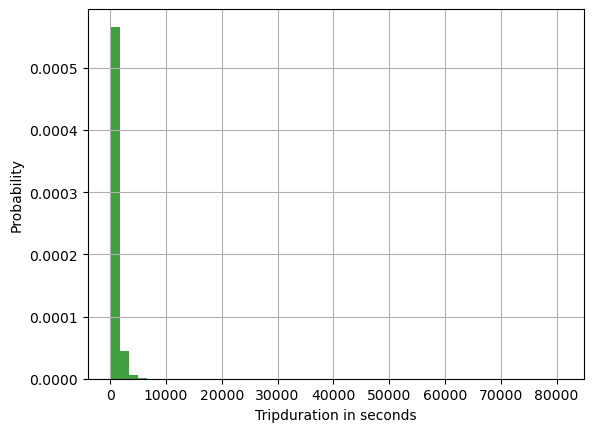

In [49]:
# histogram of the Trip_Seconds
n, bins, patches = plt.hist(df_chicago['Trip_Seconds'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Tripduration in seconds')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

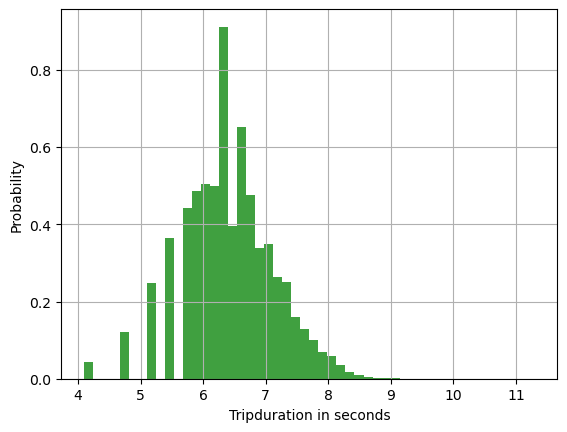

In [50]:
# histogram of the Trip_Seconds with log
n, bins, patches = plt.hist(np.log(df_chicago['Trip_Seconds']), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Tripduration in seconds')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

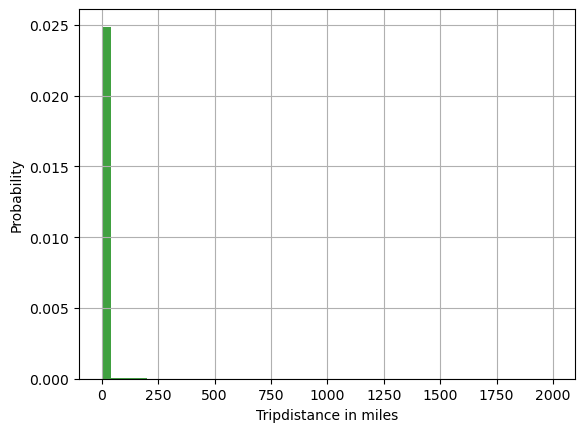

In [51]:
# histogram of the Trip_Miles
n, bins, patches = plt.hist(df_chicago['Trip_Miles'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Tripdistance in miles')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

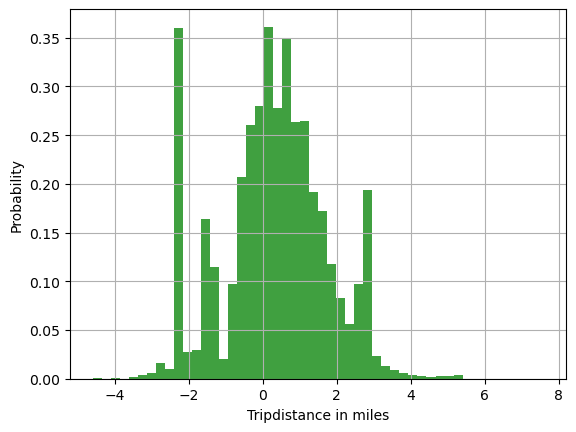

In [52]:
# histogram of the Trip_Miles with log
n, bins, patches = plt.hist(np.log(df_chicago['Trip_Miles']), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Tripdistance in miles')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

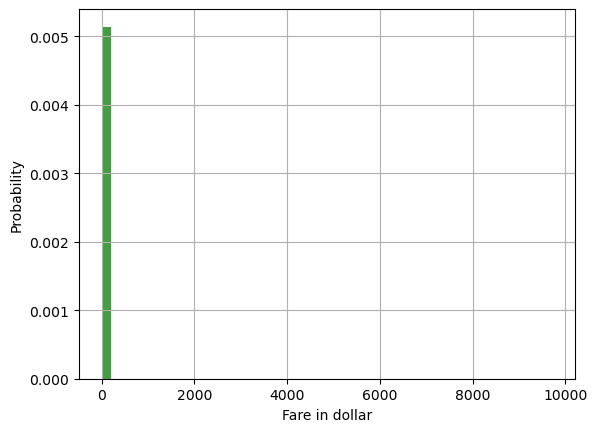

In [53]:
# histogram of the Fare
n, bins, patches = plt.hist(df_chicago['Fare'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Fare in dollar')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

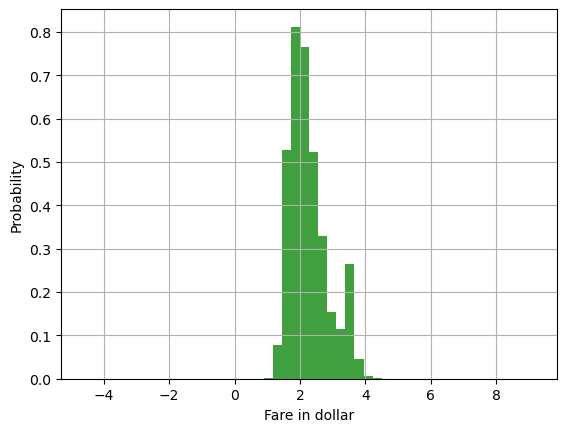

In [54]:
# histogram of the Fare with log
n, bins, patches = plt.hist(np.log(df_chicago['Fare']), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Fare in dollar')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

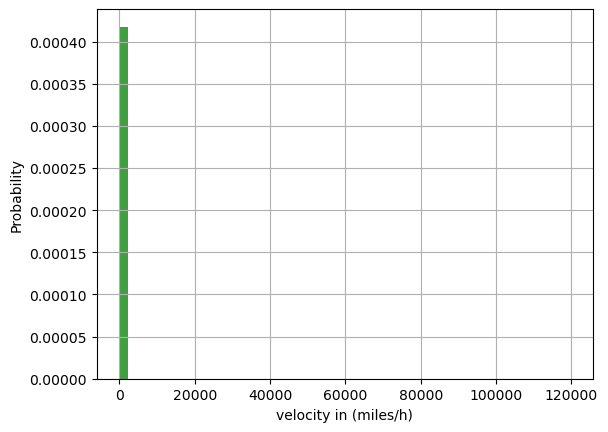

In [55]:
# histogram of the Fare
n, bins, patches = plt.hist(df_chicago['velocity_(miles/h)'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('velocity in (miles/h)')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

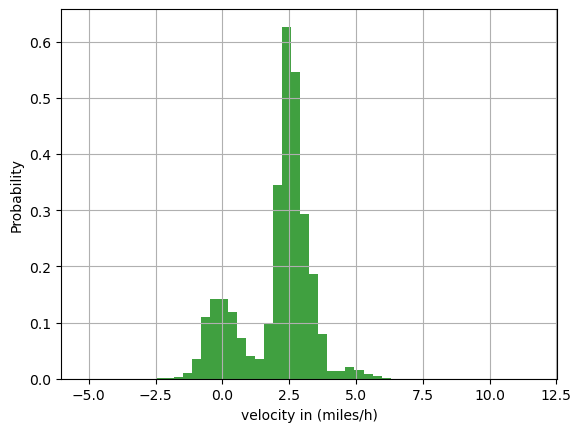

In [56]:
# histogram of the Fare with log
n, bins, patches = plt.hist(np.log(df_chicago['velocity_(miles/h)']), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('velocity in (miles/h)')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

### Remove outliers

In [57]:
from scipy.stats import zscore

def remove_outliers(df,excluded_cols=None,zscore_threshold=2,verbose=False):
    
    outlier_count = 0
    df_numeric_view = df.select_dtypes(include="number")

    for col in df_numeric_view.columns:
        if excluded_cols and col in excluded_cols:
            continue
        df[f"{col}_zscore"] = np.around(np.abs(zscore(np.log(df[col]))), decimals=1)
        outlier = df[df[f"{col}_zscore"] > zscore_threshold]
        outlier_count += outlier.shape[0]
        df.drop(outlier.index, inplace=True)
        if verbose:
            print(
                f"--> {outlier.shape[0]} outlier detected and removed from {col} column using zscore"
            )
    df = df.loc[:, ~df.columns.str.contains("zscore")]

    print(f"Outlier detection completed. Number of removed outlier: {outlier_count}")

    return df.reset_index(drop=True)

In [58]:
df_chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10892467 entries, 0 to 10892466
Data columns (total 32 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip_ID                     object        
 1   Taxi_ID                     object        
 2   Trip_Start_Timestamp        datetime64[ns]
 3   Trip_End_Timestamp          datetime64[ns]
 4   Trip_Seconds                float64       
 5   Trip_Miles                  float64       
 6   Pickup_Census_Tract         float64       
 7   Dropoff_Census_Tract        float64       
 8   Pickup_Community_Area       float64       
 9   Dropoff_Community_Area      float64       
 10  Fare                        float64       
 11  Tips                        float64       
 12  Tolls                       float64       
 13  Extras                      float64       
 14  Payment_Type                object        
 15  Pickup_Centroid_Latitude    float64       
 16  Pickup_Centroid_

In [59]:
df_chicago = remove_outliers(df_chicago,excluded_cols=['Trip_ID','Taxi_ID','Trip_Start_Timestamp',
                            'Trip_End_Timestamp','Pickup_Census_Tract','Dropoff_Census_Tract', 
                            'Pickup_Community_Area','Dropoff_Community_Area',
                            'Payment_Type','Company','Pickup_Centroid_Latitude','Pickup_Centroid_Longitude',
                            'Pickup_Centroid_Location','Dropoff_Centroid_Latitude','Dropoff_Centroid_Longitude',
                            'Dropoff_Centroid__Location','Community_Areas','Tips','Tolls','Extras','dayOfWeek',
                            'season','isRushhour','isHoliday','date_start','start_time_hourly','start_time_day',
                            'start_time_week','start_time_month']
                             ,zscore_threshold=2,verbose=True)

--> 547818 outlier detected and removed from Trip_Seconds column using zscore
--> 165923 outlier detected and removed from Trip_Miles column using zscore
--> 694962 outlier detected and removed from Fare column using zscore
--> 510038 outlier detected and removed from velocity_(miles/h) column using zscore
Outlier detection completed. Number of removed outlier: 1918741


In [60]:
df_chicago.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8973726 entries, 0 to 8973725
Data columns (total 32 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip_ID                     8973726 non-null  object        
 1   Taxi_ID                     8973726 non-null  object        
 2   Trip_Start_Timestamp        8973726 non-null  datetime64[ns]
 3   Trip_End_Timestamp          8973726 non-null  datetime64[ns]
 4   Trip_Seconds                8973726 non-null  float64       
 5   Trip_Miles                  8973726 non-null  float64       
 6   Pickup_Census_Tract         6351994 non-null  float64       
 7   Dropoff_Census_Tract        6351994 non-null  float64       
 8   Pickup_Community_Area       8973726 non-null  float64       
 9   Dropoff_Community_Area      8973726 non-null  float64       
 10  Fare                        8973726 non-null  float64       
 11  Tips                    

# 1.2 Weather data

In [61]:
#df_Weather = pd.read_csv("https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-hourly&stations=72534014819&startDate=2013-01-01&endDate=2013-12-31&format=csv&units=metric")
#df_Weather.dropna(axis=1, how = 'any')


In [62]:
# import the weather datasets

df_hum = pd.read_csv("data/weather/humidity.csv")
df_pres = pd.read_csv("data/weather/pressure.csv")
df_temp = pd.read_csv("data/weather/temperature.csv")
df_winddir = pd.read_csv("data/weather/wind_direction.csv")
df_windsp = pd.read_csv("data/weather/wind_speed.csv")
df_descr = pd.read_csv("data/weather/weather_description.csv")

## Cleaning the weather data sets:

In [63]:
# Change datatype of 'datetime' from object to datetime
df_hum['datetime'] = pd.to_datetime(df_hum['datetime'])
df_pres['datetime'] = pd.to_datetime(df_pres['datetime'])
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
df_winddir['datetime'] = pd.to_datetime(df_hum['datetime'])
df_windsp['datetime'] = pd.to_datetime(df_hum['datetime'])
df_descr['datetime'] = pd.to_datetime(df_hum['datetime'])

# Since we only look at data from 2013, we can drop all rows from other years. 
df_hum = df_hum[(df_hum['datetime']>=datetime.datetime(year=2013, month=1, day=1, hour=0, minute=0, second=0))
         & (df_hum['datetime']<=datetime.datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0))]
df_pres = df_pres[(df_pres['datetime']>=datetime.datetime(year=2013, month=1, day=1, hour=0, minute=0, second=0))
         & (df_pres['datetime']<=datetime.datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0))]
df_temp = df_temp[(df_temp['datetime']>=datetime.datetime(year=2013, month=1, day=1, hour=0, minute=0, second=0))
         & (df_temp['datetime']<=datetime.datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0))]
df_winddir = df_winddir[(df_winddir['datetime']>=datetime.datetime(year=2013, month=1, day=1, hour=0, minute=0, second=0))
         & (df_winddir['datetime']<=datetime.datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0))]
df_windsp = df_windsp[(df_windsp['datetime']>=datetime.datetime(year=2013, month=1, day=1, hour=0, minute=0, second=0))
         & (df_windsp['datetime']<=datetime.datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0))]
df_descr = df_descr[(df_descr['datetime']>=datetime.datetime(year=2013, month=1, day=1, hour=0, minute=0, second=0))
         & (df_descr['datetime']<=datetime.datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0))]

# Reset index to new time intervall of 2013
df_hum.reset_index(drop=True, inplace=True)
df_pres.reset_index(drop=True, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
df_winddir.reset_index(drop=True, inplace=True)
df_windsp.reset_index(drop=True, inplace=True)
df_descr.reset_index(drop=True, inplace=True)

In [64]:
df_hum = df_hum[['Chicago','datetime']]
df_pres = df_pres[['Chicago','datetime']]
df_temp = df_temp[['Chicago','datetime']]
df_winddir = df_winddir[['Chicago','datetime']]
df_windsp = df_windsp[['Chicago','datetime']]
df_descr = df_descr[['Chicago','datetime']]

In [65]:
# Test if there are duplicate rows in dfWeather
print("There are", len(df_hum)-len(df_hum.drop_duplicates()), "duplicate rows in df_hum.")
print("There are", len(df_pres)-len(df_pres.drop_duplicates()), "duplicate rows in df_pres.")
print("There are", len(df_temp)-len(df_temp.drop_duplicates()), "duplicate rows in df_temp.")
print("There are", len(df_winddir)-len(df_winddir.drop_duplicates()), "duplicate rows in df_winddir.")
print("There are", len(df_windsp)-len(df_windsp.drop_duplicates()), "duplicate rows in df_windsp.")
print("There are", len(df_descr)-len(df_descr.drop_duplicates()), "duplicate rows in df_descr.")

There are 0 duplicate rows in df_hum.
There are 0 duplicate rows in df_pres.
There are 0 duplicate rows in df_temp.
There are 0 duplicate rows in df_winddir.
There are 0 duplicate rows in df_windsp.
There are 0 duplicate rows in df_descr.


In [66]:
# Test for datetime duplicates
print("There are", len(df_hum)-len(df_hum.drop_duplicates(subset='datetime')), "datetime duplicates in df_hum.")
print("There are", len(df_pres)-len(df_pres.drop_duplicates(subset='datetime')), "datetime duplicates in df_pres.")
print("There are", len(df_temp)-len(df_temp.drop_duplicates(subset='datetime')), "datetime duplicates in df_temp.")
print("There are", len(df_winddir)-len(df_winddir.drop_duplicates(subset='datetime')), "datetime duplicates in df_winddir.")
print("There are", len(df_windsp)-len(df_windsp.drop_duplicates(subset='datetime')), "datetime duplicates in df_windsp.")
print("There are", len(df_descr)-len(df_descr.drop_duplicates(subset='datetime')), "datetime duplicates in df_descr.")

There are 0 datetime duplicates in df_hum.
There are 0 datetime duplicates in df_pres.
There are 0 datetime duplicates in df_temp.
There are 0 datetime duplicates in df_winddir.
There are 0 datetime duplicates in df_windsp.
There are 0 datetime duplicates in df_descr.


In [67]:
df_hum = df_hum[:-1]
df_pres = df_pres[:-1]
df_temp = df_temp[:-1]
df_winddir = df_winddir[:-1]
df_windsp = df_windsp[:-1]
df_descr = df_descr[:-1]

In [68]:
df_hum.rename(columns = {'Chicago':'humidity'},inplace=True)
df_pres.rename(columns = {'Chicago':'pressure'},inplace=True)
df_temp.rename(columns = {'Chicago':'temperature'},inplace=True)
df_winddir.rename(columns = {'Chicago':'wind_direction'},inplace=True)
df_windsp.rename(columns = {'Chicago':'wind_speed'},inplace=True)
df_descr.rename(columns = {'Chicago':'description'},inplace=True)

## Creating dataframe `df_weather`

In [69]:
df_weather = pd.merge(df_pres, df_hum, on=["datetime"], how="left")
df_weather = pd.merge(df_weather, df_temp, on=["datetime"], how="left")
df_weather = pd.merge(df_weather, df_winddir, on=["datetime"], how="left")
df_weather = pd.merge(df_weather, df_windsp, on=["datetime"], how="left")
df_weather = pd.merge(df_weather, df_descr, on=["datetime"], how="left")

### Edit features and interpolate:

In [70]:
df_weather['temperature'] = df_weather['temperature'] - 273.15

In [71]:
df_weather.rename(columns = {'temperature':'temperature_celsius'},inplace=True)

In [72]:
df_weather

,pressure,datetime,humidity,temperature_celsius,wind_direction,wind_speed,description
0,1024.0,2013-01-01 00:00:00,NaN,-0.19,200.0,4.0,overcast clouds
1,1022.0,2013-01-01 01:00:00,64.0,0.28,180.0,3.0,broken clouds
2,1022.0,2013-01-01 02:00:00,69.0,0.33,190.0,6.0,overcast clouds
3,1021.0,2013-01-01 03:00:00,NaN,0.12,190.0,7.0,overcast clouds
4,1021.0,2013-01-01 04:00:00,68.0,0.04,210.0,7.0,broken clouds
...,...,...,...,...,...,...,...
8755,1026.0,2013-12-31 19:00:00,89.0,-11.27,289.0,0.0,broken clouds
8756,1026.0,2013-12-31 20:00:00,89.0,-10.60,269.0,0.0,broken clouds
8757,1026.0,2013-12-31 21:00:00,89.0,-10.98,329.0,3.0,light snow
8758,1026.0,2013-12-31 22:00:00,89.0,-11.24,241.0,1.0,snow


In [73]:
print(f"Number of null values (NaN) in column 'description': {len(df_weather['description'])-len(df_weather['description'].dropna())}")
print(f"Number of null values (NaN) in column 'pressure': {len(df_weather['pressure'])-len(df_weather['pressure'].dropna())}")
print(f"Number of null values (NaN) in column 'humidity': {len(df_weather['humidity'])-len(df_weather['humidity'].dropna())}")
print(f"Number of null values (NaN) in column 'temperature_celsius': {len(df_weather['temperature_celsius'])-len(df_weather['temperature_celsius'].dropna())}")
print(f"Number of null values (NaN) in column 'wind_direction': {len(df_weather['wind_direction'])-len(df_weather['wind_direction'].dropna())}")
print(f"Number of null values (NaN) in column 'wind_speed': {len(df_weather['wind_speed'])-len(df_weather['wind_speed'].dropna())}")

Number of null values (NaN) in column 'description': 0
Number of null values (NaN) in column 'pressure': 557
Number of null values (NaN) in column 'humidity': 628
Number of null values (NaN) in column 'temperature_celsius': 2
Number of null values (NaN) in column 'wind_direction': 0
Number of null values (NaN) in column 'wind_speed': 0


In [74]:
for column in ['temperature_celsius','humidity','pressure']:
    df_weather[column].interpolate(method='linear', limit_direction='both', inplace=True)

In [75]:
df_weather

,pressure,datetime,humidity,temperature_celsius,wind_direction,wind_speed,description
0,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds
1,1022.0,2013-01-01 01:00:00,64.0,0.28,180.0,3.0,broken clouds
2,1022.0,2013-01-01 02:00:00,69.0,0.33,190.0,6.0,overcast clouds
3,1021.0,2013-01-01 03:00:00,68.5,0.12,190.0,7.0,overcast clouds
4,1021.0,2013-01-01 04:00:00,68.0,0.04,210.0,7.0,broken clouds
...,...,...,...,...,...,...,...
8755,1026.0,2013-12-31 19:00:00,89.0,-11.27,289.0,0.0,broken clouds
8756,1026.0,2013-12-31 20:00:00,89.0,-10.60,269.0,0.0,broken clouds
8757,1026.0,2013-12-31 21:00:00,89.0,-10.98,329.0,3.0,light snow
8758,1026.0,2013-12-31 22:00:00,89.0,-11.24,241.0,1.0,snow


## Merging `df_chicago` and `df_weather` to `df_chicago`

In [76]:
df_chicago = pd.merge(df_chicago, df_weather, left_on="Trip_Start_Timestamp",right_on="datetime", how="left")
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,start_time_month,isRushhour,velocity_(miles/h),pressure,datetime,humidity,temperature_celsius,wind_direction,wind_speed,description
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01,900.0,2.7,NaN,NaN,28.0,8.0,...,1,False,10.800000,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,1,False,6.000000,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,1,False,1.125000,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01,180.0,1.0,NaN,NaN,24.0,24.0,...,1,False,20.000000,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01,240.0,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,1,False,4.500000,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8973721,69c7d0ae0ed40968099fa6204038d8c2c3f66388,2f0f051b1f6d6ca49b2d99fc023b3bb77b844b3797f184...,2013-12-31 23:00:00,2014-01-01,840.0,2.8,1.703108e+10,1.703124e+10,8.0,24.0,...,12,False,12.000000,1023.0,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist
8973722,1bf42206af9397f2102333d0b669842458f9a798,330a881b0f3d1450ebb5825aec2551ee4cd5f7c309312b...,2013-12-31 23:00:00,2014-01-01,480.0,2.4,NaN,NaN,17.0,10.0,...,12,False,18.000000,1023.0,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist
8973723,a14363f70f81f861de5873fd5e5d52ba9a0cdcea,8bb72e3ef6a7494b80eb3bbf7777b467d4195a1ee71b35...,2013-12-31 23:00:00,2014-01-01,1200.0,2.5,1.703106e+10,1.703107e+10,6.0,7.0,...,12,False,7.500000,1023.0,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist
8973724,4b33dafe9a5961d5ce31c00cd55ef8d09bc2d26a,f6b124d1dc514ef12491489d89b730285779761ebd9292...,2013-12-31 23:00:00,2014-01-01,1980.0,7.8,1.703104e+10,1.703108e+10,4.0,8.0,...,12,False,14.181818,1023.0,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist


In [77]:
df_chicago.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8973726 entries, 0 to 8973725
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip_ID                     8973726 non-null  object        
 1   Taxi_ID                     8973726 non-null  object        
 2   Trip_Start_Timestamp        8973726 non-null  datetime64[ns]
 3   Trip_End_Timestamp          8973726 non-null  datetime64[ns]
 4   Trip_Seconds                8973726 non-null  float64       
 5   Trip_Miles                  8973726 non-null  float64       
 6   Pickup_Census_Tract         6351994 non-null  float64       
 7   Dropoff_Census_Tract        6351994 non-null  float64       
 8   Pickup_Community_Area       8973726 non-null  float64       
 9   Dropoff_Community_Area      8973726 non-null  float64       
 10  Fare                        8973726 non-null  float64       
 11  Tips                    

# 1.3 Creating/Preparing Spatial data

We first start with understanding the given spatial information from `df_chicago`.  
For this we look at the columns `Pickup_Census_Tract`, `Pickup_Community_Area`, & `Pickup_Centroid_Latitude and Pickup_Centroid_Longitude`. We are only interested in the start location of the trip.  
According to https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew#column-menu:
- `Pickup_Census_Tract`: "The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago."
- `Pickup_Community_Area`: "The Community Area where the trip began. This column will be blank for locations outside Chicago."
- `Pickup_Centroid_Latitude and Pickup_Centroid_Longitude`: "The latitude/longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This columns often will be blank for locations outside Chicago."

In [78]:
df_chicago[["Pickup_Census_Tract"]].nunique()

Pickup_Census_Tract    365
dtype: int64

In [79]:
df_chicago[["Pickup_Community_Area"]].nunique()

Pickup_Community_Area    77
dtype: int64

In [80]:
df_chicago[["Pickup_Centroid_Latitude", "Pickup_Centroid_Longitude"]].nunique()

Pickup_Centroid_Latitude     442
Pickup_Centroid_Longitude    442
dtype: int64

In [81]:
unique_pairs = df_chicago[["Pickup_Centroid_Latitude", "Pickup_Centroid_Longitude"]].drop_duplicates().shape[0]
print("Pickup_Centroid_Latitude and Pickup_Centroid_Longitude form", unique_pairs, "unique pairs.")

if int(df_chicago[["Pickup_Census_Tract"]].nunique()) + int(df_chicago[["Pickup_Community_Area"]].nunique()) == unique_pairs:
    print("\nEvery Pickup_Census_Tract and Pickup_Community_Area are included in the pairs of Pickup_Centroid_Latitude & Pickup_Centroid_Longitude.\nIt is enough to use this values for the generation/preparation of spatial data!")

Pickup_Centroid_Latitude and Pickup_Centroid_Longitude form 442 unique pairs.

Every Pickup_Census_Tract and Pickup_Community_Area are included in the pairs of Pickup_Centroid_Latitude & Pickup_Centroid_Longitude.
It is enough to use this values for the generation/preparation of spatial data!


Now we want to **split the coordinates for `Pickup_Census_Tract` and `Pickup_Community_Area`**:

**Split the coordinates for `Pickup_Census_Tract`**:

In [82]:
# Get Every Census Tract
dfPickupCensusTract = df_chicago[["Pickup_Census_Tract","Pickup_Centroid_Latitude", "Pickup_Centroid_Longitude"]].drop_duplicates(subset=["Pickup_Census_Tract"])
# Drop the Null value
dfPickupCensusTract.dropna(inplace=True)
dfPickupCensusTract

,Pickup_Census_Tract,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude
1,1.703107e+10,41.928967,-87.656157
2,1.703122e+10,41.921126,-87.699754
4,1.703128e+10,41.879255,-87.642649
6,1.703108e+10,41.892073,-87.628874
7,1.703108e+10,41.893216,-87.637844
...,...,...,...
8388783,1.703115e+10,41.960518,-87.762286
8440395,1.703122e+10,41.926156,-87.721565
8619102,1.703102e+10,42.008541,-87.694964
8650376,1.703184e+10,41.844661,-87.649072


In [83]:
# Only keep coordinates for h3-Uber
dfPickupCensusTractCoordinates = dfPickupCensusTract.drop("Pickup_Census_Tract", axis=1)

**Split the coordinates for `Pickup_Community_Area`**:

In [84]:
# Get Every Community Area
dfPickupCommunityArea = df_chicago[["Pickup_Community_Area","Pickup_Centroid_Latitude", "Pickup_Centroid_Longitude"]].drop_duplicates(subset=["Pickup_Community_Area"])
# Drop potential Null value
dfPickupCommunityArea.dropna(inplace=True)
dfPickupCommunityArea

,Pickup_Community_Area,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude
0,28.0,41.874005,-87.663518
1,7.0,41.928967,-87.656157
2,22.0,41.921126,-87.699754
3,24.0,41.901207,-87.676356
6,8.0,41.892073,-87.628874
...,...,...,...
133401,75.0,41.689730,-87.669054
413032,53.0,41.673820,-87.635740
910190,74.0,41.694879,-87.713192
1997206,54.0,41.660136,-87.602848


In [85]:
# Only keep coordinates for h3-Uber
dfPickupCommunityAreaCoordinates = dfPickupCommunityArea.drop("Pickup_Community_Area", axis=1)

Now we can start to discretize the city with the help of h3-Uber.

## H3-Uber

**H3-Uber FEATURES: `h3_hex_id_high_res`, `h3_hex_id_medium_res` & `h3_hex_id_low_res`**

In [86]:
#pip install h3

In [87]:
#pip install folium

In [88]:
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=11, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [89]:
## Lists of coordinates to be covered by hexagons
#geoJsonPickupCensusTract = {'type': 'Polygon',
# 'coordinates': [dfPickupCensusTractCoordinates.values.tolist()] }
#geoJsonPickupCommunityArea = {'type': 'Polygon',
# 'coordinates': [dfPickupCommunityAreaCoordinates.values.tolist()] }
#
## Generate hexagons covering the included coordinates
#hexagonsPickupCensusTract = list(h3.polyfill(geoJsonPickupCensusTract, 8))
#hexagonsPickupCommunityArea = list(h3.polyfill(geoJsonPickupCommunityArea, 7))
#
## Generate Map
#m = visualize_hexagons(hexagonsPickupCensusTract, color="red")
#m = visualize_hexagons(hexagonsPickupCommunityArea, color="blue", folium_map=m)
#display(m)

In [90]:
#print("We have", len(hexagonsPickupCensusTract), "hexagons for Pickup_Census_Tract, but we have", int(df_chicago[["Pickup_Census_Tract"]].nunique()), "unique Pickup_Census_Tract in the data.")
#print("We have", len(hexagonsPickupCommunityArea), "hexagons for Pickup_Community_Area, but we have", int(df_chicago[["Pickup_Community_Area"]].nunique()), "unique Pickup_Community_Area in the data.")

**2nd Try**

In [93]:
import geopandas
import json
city_bounding = geopandas.read_file('data/boundaries_city.geojson')
city_bounding_json_string = city_bounding.to_json()
city_bounding_json = json.loads(city_bounding_json_string)
city_bounding_poly = city_bounding_json["features"][0]

<Axes: >

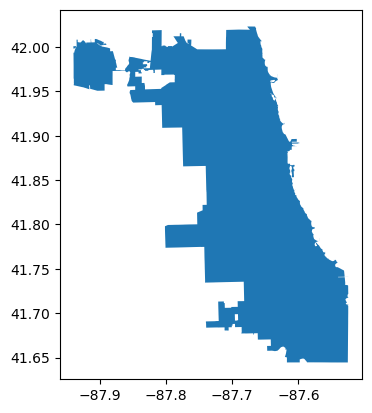

In [94]:
city_bounding.plot()

In [95]:
city_bounding_poly["geometry"]["type"]

'MultiPolygon'

In [96]:
# Create a GeoDataFrame from the MultiPolygon
gdf = geopandas.GeoDataFrame.from_features([city_bounding_poly])

# Explode the MultiPolygon into individual polygons
exploded_city_bounding_poly = gdf.explode()

exploded_city_bounding_poly

C:\Users\Benny\AppData\Local\Temp\ipykernel_22140\3466830845.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded_city_bounding_poly = gdf.explode()


name objectid     shape_area      shape_len  \
0 0  CHICAGO        1  6450276623.31  845282.931362   
  1  CHICAGO        1  6450276623.31  845282.931362   

                                              geometry  
0 0  POLYGON ((-87.93514 42.00089, -87.93521 42.000...  
  1  POLYGON ((-87.93514 42.00089, -87.93509 42.000...

In [97]:
# Get both Polygons
cityBoundingPolygonSmall = {'type': 'Polygon', 'coordinates': city_bounding_poly["geometry"]["coordinates"][0]}
cityBoundingPolygonBig = {'type': 'Polygon', 'coordinates': city_bounding_poly["geometry"]["coordinates"][1]}

In [98]:
#from h3 import h3 
from shapely.geometry import shape

# Computing hexagons for a given polygon
H3_HEXAGON_HIGH_RESOLUTION = 8
H3_HEXAGON_MEDIUM_RESOLUTION = 7
H3_HEXAGON_LOW_RESOLUTION = 6

hexagonsChicagoSmallPartHighRes = h3.polyfill(cityBoundingPolygonSmall, res = H3_HEXAGON_HIGH_RESOLUTION, geo_json_conformant = True)
hexagonsChicagoBigPartHighRes = h3.polyfill(cityBoundingPolygonBig, res = H3_HEXAGON_HIGH_RESOLUTION, geo_json_conformant = True)
hexagonsChicagoBigPartMediumRes = h3.polyfill(cityBoundingPolygonBig, res = H3_HEXAGON_MEDIUM_RESOLUTION, geo_json_conformant = True)
hexagonsChicagoBigPartLowRes = h3.polyfill(cityBoundingPolygonBig, res = H3_HEXAGON_LOW_RESOLUTION, geo_json_conformant = True)

In [100]:
hexagonsChicagoSmallPartHighRes

set()

For H3_HEXAGON_RESOLUTION <= 8 is hexagonsChicagoSmallPart empty.   
Because of this we use only hexagonsChicagoBigPart in the following:

In [101]:
# Generate Map
#m = visualize_hexagons(hexagonsChicagoSmallPartHighRes, color="red") # We don't need this, because H3_HEXAGON_RESOLUTION <= 8
m = visualize_hexagons(hexagonsChicagoBigPartHighRes, color="orange")
m = visualize_hexagons(hexagonsChicagoBigPartMediumRes, color="darkgreen", folium_map=m)
m = visualize_hexagons(hexagonsChicagoBigPartLowRes, color="darkblue", folium_map=m)
display(m)

In [102]:
print("We have", len(hexagonsChicagoBigPartHighRes), "hexagons for H3_HEXAGON_HIGH_RESOLUTION.")
print("We have", len(hexagonsChicagoBigPartMediumRes), "hexagons for H3_HEXAGON_MEDIUM_RESOLUTION.")
print("We have", len(hexagonsChicagoBigPartLowRes), "hexagons for H3_HEXAGON_LOW_RESOLUTION.")

We have 809 hexagons for H3_HEXAGON_HIGH_RESOLUTION.
We have 116 hexagons for H3_HEXAGON_MEDIUM_RESOLUTION.
We have 17 hexagons for H3_HEXAGON_LOW_RESOLUTION.


Now that we have decided analytically for an optimal selection of hexagon resolutions, we can apply the h3_hex_id's to our dataset:

**Create a dataframe with unique coordinates to shorten the runtime:**

In [103]:
unique_start_coordinates = df_chicago[["Pickup_Centroid_Latitude", "Pickup_Centroid_Longitude"]].drop_duplicates()

In [104]:
unique_start_coordinates

,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude
0,41.874005,-87.663518
1,41.928967,-87.656157
2,41.921126,-87.699754
3,41.901207,-87.676356
4,41.879255,-87.642649
...,...,...
8388783,41.960518,-87.762286
8440395,41.926156,-87.721565
8619102,42.008541,-87.694964
8650376,41.844661,-87.649072


In [105]:
# Get the hexagons
from shapely.geometry.polygon import Polygon

unique_start_coordinates["h3_hex_id_high_res"] = unique_start_coordinates.apply(lambda row: h3.geo_to_h3(row["Pickup_Centroid_Latitude"], row["Pickup_Centroid_Longitude"], H3_HEXAGON_HIGH_RESOLUTION) if (row['Pickup_Centroid_Latitude'] and row['Pickup_Centroid_Longitude']) else 0, axis=1)
unique_start_coordinates["h3_hex_id_medium_res"] = unique_start_coordinates.apply(lambda row: h3.geo_to_h3(row["Pickup_Centroid_Latitude"], row["Pickup_Centroid_Longitude"], H3_HEXAGON_MEDIUM_RESOLUTION) if (row['Pickup_Centroid_Latitude'] and row['Pickup_Centroid_Longitude']) else 0, axis=1)
unique_start_coordinates["h3_hex_id_low_res"] = unique_start_coordinates.apply(lambda row: h3.geo_to_h3(row["Pickup_Centroid_Latitude"], row["Pickup_Centroid_Longitude"], H3_HEXAGON_LOW_RESOLUTION) if (row['Pickup_Centroid_Latitude'] and row['Pickup_Centroid_Longitude']) else 0, axis=1)

unique_start_coordinates

,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res
0,41.874005,-87.663518,882664ca91fffff,872664ca9ffffff,862664cafffffff
1,41.928967,-87.656157,882664c12bfffff,872664c12ffffff,862664c17ffffff
2,41.921126,-87.699754,882664ca11fffff,872664ca1ffffff,862664ca7ffffff
3,41.901207,-87.676356,882664cac3fffff,872664cacffffff,862664cafffffff
4,41.879255,-87.642649,882664c1adfffff,872664c1affffff,862664c1fffffff
...,...,...,...,...,...
8388783,41.960518,-87.762286,882664cb59fffff,872664d9bffffff,862664cb7ffffff
8440395,41.926156,-87.721565,882664ca39fffff,872664ca3ffffff,862664ca7ffffff
8619102,42.008541,-87.694964,882664d8edfffff,872664d8effffff,862664d8fffffff
8650376,41.844661,-87.649072,882664cf47fffff,872664cf4ffffff,862664cf7ffffff


In [106]:
# Merge the hexagoninformation into df_chicago
df_chicago = pd.merge(df_chicago, unique_start_coordinates, on=["Pickup_Centroid_Latitude", "Pickup_Centroid_Longitude"], how="left")
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,pressure,datetime,humidity,temperature_celsius,wind_direction,wind_speed,description,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01,900.0,2.7,NaN,NaN,28.0,8.0,...,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664ca91fffff,872664ca9ffffff,862664cafffffff
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664c12bfffff,872664c12ffffff,862664c17ffffff
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664ca11fffff,872664ca1ffffff,862664ca7ffffff
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01,180.0,1.0,NaN,NaN,24.0,24.0,...,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664cac3fffff,872664cacffffff,862664cafffffff
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01,240.0,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,1024.0,2013-01-01 00:00:00,64.0,-0.19,200.0,4.0,overcast clouds,882664c1adfffff,872664c1affffff,862664c1fffffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8973721,69c7d0ae0ed40968099fa6204038d8c2c3f66388,2f0f051b1f6d6ca49b2d99fc023b3bb77b844b3797f184...,2013-12-31 23:00:00,2014-01-01,840.0,2.8,1.703108e+10,1.703124e+10,8.0,24.0,...,1023.0,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist,882664c1ebfffff,872664c1effffff,862664c1fffffff
8973722,1bf42206af9397f2102333d0b669842458f9a798,330a881b0f3d1450ebb5825aec2551ee4cd5f7c309312b...,2013-12-31 23:00:00,2014-01-01,480.0,2.4,NaN,NaN,17.0,10.0,...,1023.0,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist,882664cb05fffff,872664cb0ffffff,862664cb7ffffff
8973723,a14363f70f81f861de5873fd5e5d52ba9a0cdcea,8bb72e3ef6a7494b80eb3bbf7777b467d4195a1ee71b35...,2013-12-31 23:00:00,2014-01-01,1200.0,2.5,1.703106e+10,1.703107e+10,6.0,7.0,...,1023.0,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist,882664c145fffff,872664c16ffffff,862664c17ffffff
8973724,4b33dafe9a5961d5ce31c00cd55ef8d09bc2d26a,f6b124d1dc514ef12491489d89b730285779761ebd9292...,2013-12-31 23:00:00,2014-01-01,1980.0,7.8,1.703104e+10,1.703108e+10,4.0,8.0,...,1023.0,2013-12-31 23:00:00,89.0,-11.00,217.0,1.0,mist,882664d8b1fffff,872664d8bffffff,862664d8fffffff


**?Refinement of FEATURE: `Pickup_Census_Tract`**

Potential export for building maps (for mapping values of `Pickup_Census_Tract` to coordinates)

In [ ]:
dfPickupCensusTract

**?Refinement of FEATURE: `Pickup_Community_Area`**

Potential export for building maps (for mapping values of `Pickup_Community_Area` to coordinates)

In [ ]:
dfPickupCommunityArea

# 1.4 Creating different forecast periods

## Creating dataframe `df_chicago_hourly`

In [ ]:
# Create temporary dataframe dfNumOfRentedBikes
df_chicago_hourly = df_chicago[["date_start", "start_time_hourly"]]
df_chicago_hourly['numOfTaxisHourly'] = 0
df_chicago_hourly.head()

In [ ]:
# Calculate numOfRentedBikesHourly for each start_date & start_time_hourly
df_chicago_hourly = df_chicago_hourly.groupby(["date_start", "start_time_hourly"])['numOfTaxisHourly'].count().reset_index()
df_chicago_hourly

In [ ]:
df_chicago_hourly = pd.merge(df_chicago, df_chicago_hourly, on=["date_start", "start_time_hourly"], how="left")
df_chicago_hourly

In [ ]:
df_chicago_hourly.drop(columns=['Trip_ID','Taxi_ID','Pickup_Census_Tract','Dropoff_Census_Tract', 
                            'Pickup_Community_Area','Dropoff_Community_Area',
                            'Payment_Type','Pickup_Centroid_Latitude','Pickup_Centroid_Longitude',
                            'Pickup_Centroid_Location','Dropoff_Centroid_Latitude','Dropoff_Centroid_Longitude',
                            'Dropoff_Centroid__Location','Community_Areas','Tips','Tolls','Extras',
                                'Trip_Miles','Trip_Seconds','Fare','velocity_(miles/h)']
                       , inplace = True)

In [ ]:
df_chicago_hourly.drop_duplicates(subset=['Trip_Start_Timestamp'], inplace = True)

In [ ]:
df_chicago_hourly = df_chicago_hourly.reset_index(drop = True)

In [ ]:
df_chicago_hourly.drop(columns=['datetime'],inplace=True)

In [ ]:
df_chicago_hourly

## Creating function for different periods

In [ ]:
def period(df, period):
    
    #df_period = df[["date_start", "start_time_hourly"]]
    #df_period['numOfTaxis'] = 0
    num_groups = len(df) // period

    # Initialize an empty DataFrame for the results
    df_period = pd.DataFrame()

    # Iterate over the groups and sum the 'x' column
    for i in range(num_groups):
        group_start = i * period  # Starting index of the group
        group_end = (i + 1) * period  # Ending index of the group
        group_sum = df.iloc[group_start:group_end]['numOfTaxisHourly'].sum()  # Sum the 'x' column in the group
        group_data = pd.DataFrame({'numOfTaxisHourly': [group_sum], 
                        'start_time_hourly': [df.iloc[group_start]['start_time_hourly']],
                        'date_start': [df.iloc[group_start]['date_start']],
                        'dayOfWeek': [df.iloc[group_start]['dayOfWeek']],
                        'isHoliday': [df.iloc[group_start]['isHoliday']],
                        'start_time_day': [df.iloc[group_start]['start_time_day']],
                        'start_time_week': [df.iloc[group_start]['start_time_week']],
                        'start_time_month': [df.iloc[group_start]['start_time_month']],
                        'start_time_day': [df.iloc[group_start]['start_time_day']],
                        'pressure': [df.iloc[group_start]['pressure']],
                        'humidity': [df.iloc[group_start]['humidity']],
                        'wind_direction': [df.iloc[group_start]['wind_direction']],
                        'wind_speed': [df.iloc[group_start]['wind_speed']],
                        'description': [df.iloc[group_start]['description']],
                        'temperature_celsius': [df.iloc[group_start]['temperature_celsius']]
                                  
                                  
                                 })  
        # Create a DataFrame with the summed 'x' value
        df_period = pd.concat([df_period, group_data], ignore_index=True)  
    
    df_period.rename(columns = {'numOfTaxisHourly':'numOfTaxis'},inplace=True)
        
    return df_period

In [ ]:
df_2 =  period(df_chicago_hourly, 2)

In [ ]:
df_6 =  period(df_chicago_hourly, 6)

In [ ]:
df_24 =  period(df_chicago_hourly, 24)

# 1.5 Creating different spatial units

## Creating function

Here we create the dataframe `df_chicago_area`, which contains hourly data grouped by the community areas.

In [ ]:
df_chicago_area = df_chicago[["date_start" , "start_time_hourly", "Pickup_Community_Area"]]
df_chicago_area['numOfTaxis_area'] = 0
df_chicago_area.head()

In [ ]:
df_chicago_area = df_chicago_area.groupby(["date_start", "start_time_hourly", "Pickup_Community_Area"])['numOfTaxis_area'].count().reset_index()
df_chicago_area

In [ ]:
#df_chicago_area =

In [ ]:
#df_chicago_hex =